![](Pictures/2017-09-08_1138.png)

- Задача: разработка модели предсказания оценки по тексту отзыва.
- Данные: отзывы о товарах с сайта mvideo.ru, оценки, которые поставлены авторами отзыва, категория и брэнд товара. 
- Цель: Предсказание общей оценки товара

## Импортируем необходимые библиотеки

In [1]:
import sys
sys.path.append("/usr/bin/python3")
sys.path.append("/usr/local/lib/python3.5/site-packages")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import string
import re

import warnings
warnings.filterwarnings("ignore")
import pandas_profiling

## Познакомимся с данными

In [2]:
X = pd.read_csv("X_train.csv")

In [3]:
X.head(2)

,sku,categoryLevel1Id,categoryLevel2Id,brandId,property,userName,reting,date,comment,commentNegative,commentPositive
0,20005023,401,4010201,826,"[{34: 'f982777489055c6563d68c005fd24aad'}, {36...",b2898a81b45310b30beb8fc0c0a9ce1e,2.0,2013-06-28,"2,5 года работала и все...устала! Лампочка гор...",NaN,NaN
1,20020647,403,4030101,1425,"[{34: '9ce895413ebdf6b6dcb69b07dc782591'}, {36...",538c73d64461e13907bb95c51c38bfbc,2.0,2010-07-04,Через 2 месяца после истечении гарантийного ср...,NaN,NaN


In [4]:
#pandas_profiling.ProfileReport(X)

## Выделим целевую переменную и преобразуем её в дискретный вид, чтобы свести задачу к классификации

In [5]:
y = X.reting

In [6]:
def discretize(y):
    if y < 2:
        y = 1
    elif y < 3:
        y = 2
    elif y < 4:
        y = 3
    elif y < 5:
        y = 4
    else:
        y = 5
    return y

In [7]:
y = y.apply(discretize)

**Без особой потери информации перевели оценки в пять классов**

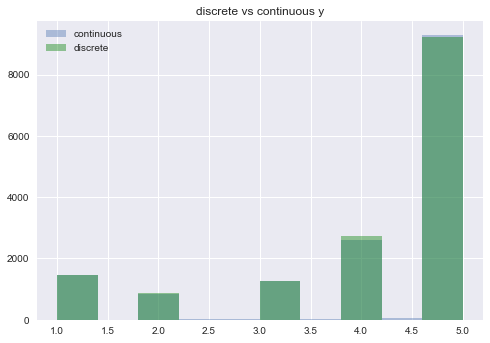

In [8]:
X.reting.hist(alpha=0.4, label = "continuous")
y.hist(alpha=0.4, label = "discrete", color="g")
plt.title("discrete vs continuous y")
plt.legend();

Как обычно, на равномерное распределение классов рассчитывать не приходится, есть значительный дисбаланс в сторону положительных отзывов (5), а значит имеет смысл либо попытаться балансировать классы при помощи down/over сэмплинга и выставления весов для наблюдений разных классов при обучении, либо попытаться построить два класса моделей - для бинарного предсказания, является отзыв отличным (5) или нет (любая другая оценка), и отдельно для случаев, когда оценка не является отличной, предсказывать остальные классы.

Для начала попробуем первый подход

Склеиваем все доступные текстовые поля вместе, очищаем от пунктуации и стоп-слов и лемматизируем

In [9]:
All_comments = X.comment.fillna(" ") + ' ' + X.commentNegative.fillna(" ") + ' ' + X.commentPositive.fillna(" ")

In [10]:
from pymystem3 import Mystem

m = Mystem()
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

    
def cleanString(myString):
    return re.sub(r'[^\w\s]','',myString)

In [11]:
All_comments_lemmatized = All_comments.apply(lemmatize)

In [12]:
All_comments_lemmatized.head()

0    2,5 год работать и все...уставать! лампочка го...
1    через 2 месяц после истечение гарантийный срок...
2    пользоваться уже три неделя. нарекание ни како...
3    ребята этот системный блок подходить для игра ...
4    я считать, что ярь замечательный телефон! прия...
dtype: object

In [13]:
All_comments_lemmatized = All_comments_lemmatized.apply(cleanString)

In [14]:
All_comments_lemmatized = All_comments_lemmatized.apply(cleanString)

In [15]:
All_comments_lemmatized.head()

0    25 год работать и всеуставать лампочка гореть ...
1    через 2 месяц после истечение гарантийный срок...
2    пользоваться уже три неделя нарекание ни какой...
3    ребята этот системный блок подходить для игра ...
4    я считать что ярь замечательный телефон приятн...
dtype: object

In [16]:
from PIL import Image
from wordcloud import WordCloud

import pymorphy2
morph = pymorphy2.MorphAnalyzer()

import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
stop = stopwords.words('russian')

Добавим немного красивой визуализации в виде облака слов, куда войдут все лемматизированные прилагательные, как основные носители эмоциональной окраски отзывов

In [17]:
cloud = ''
for i in All_comments_lemmatized:
    cloud += (' '+i)
cloud = " ".join([word for word in cloud.split() if word not in stop])

adjective_cloud = ""
for word in cloud.split():
    if morph.parse(word)[0].tag.POS in ['ADJF', 'ADJS']:
        adjective_cloud = adjective_cloud + word + " "
        
adjective_cloud = adjective_cloud.replace("данный", "")

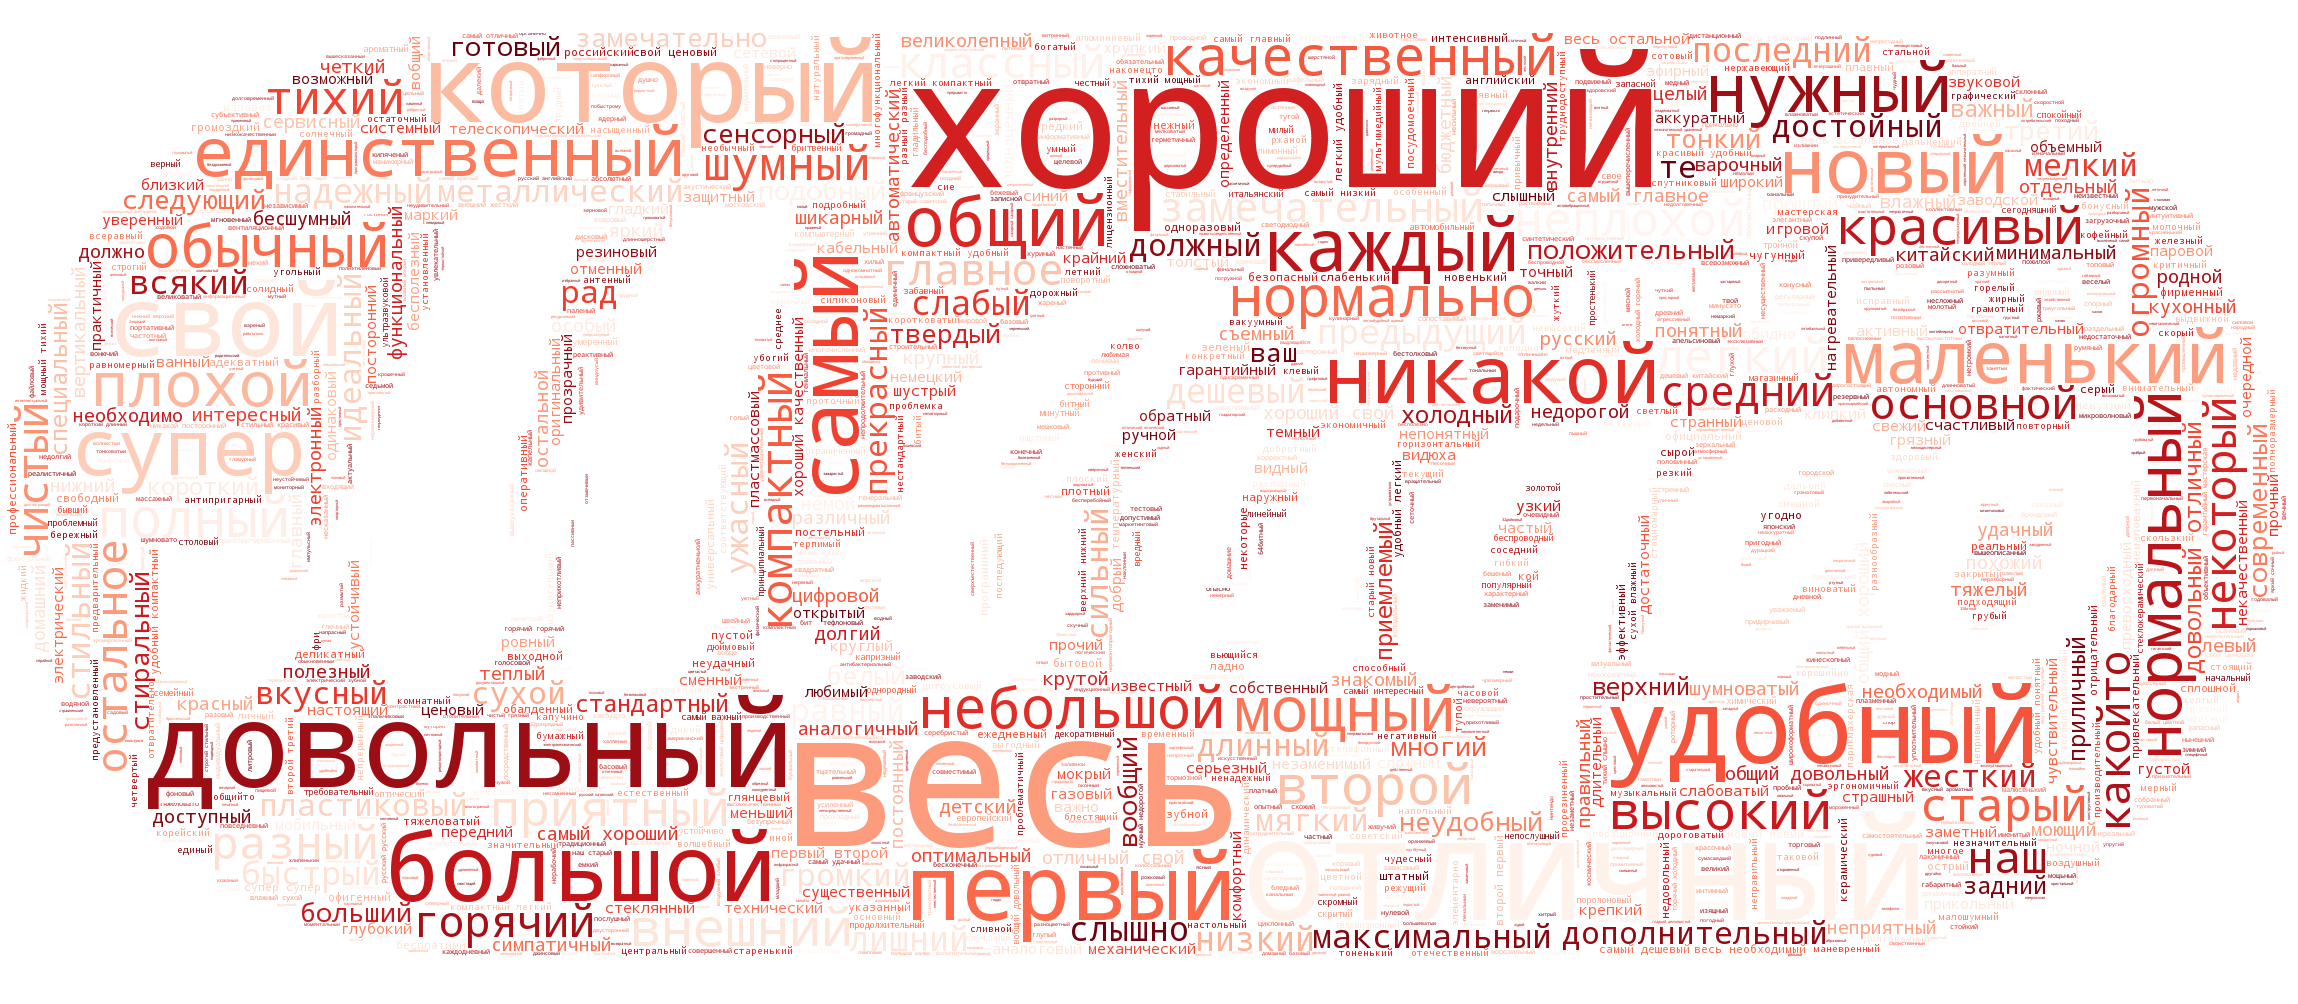

In [18]:
pic = np.array(Image.open("Pictures/Mvideo_white.png"))
wordcloud = WordCloud(background_color="white", max_words=10000, mask=pic, colormap='Reds')
wordcloud = wordcloud.generate(adjective_cloud)
wordcloud.to_image()

Как и ожидалось, большая часть встреченных слов - положительной окраски из-за дисбаланса классов

## Попробуем обучить модель 

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_vectorizer = TfidfVectorizer(stop_words=stop, ngram_range=(1, 2))

In [20]:
X_train_vector = tf_vectorizer.fit_transform(All_comments_lemmatized)
X_train_vector.shape

(15587, 362511)

In [21]:
Xtr, Xval, ytr, yval  = train_test_split(X_train_vector, y, test_size=0.30, random_state=42)

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

Так как признаковое пространство сильно разреженное после tf-idf преобразования, неплохо использовать линейные модели, в частности - логистическую регрессию

In [23]:
logit_sgd = SGDClassifier(loss='log', random_state=42, class_weight="balanced", n_iter=100, n_jobs=-1)

In [24]:
logit_sgd.fit(Xtr, ytr)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=100, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [25]:
def visualize_coefficients(coef, feature_names, title, plot_num, n_top_features=15):
    interesting_coefficients = np.argsort(coef)[-n_top_features:]
    
    plt.figure(figsize=(10, 15))
    plt.subplot(510+plot_num+1)
    colors = ["blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, 1 + n_top_features), 
               feature_names[interesting_coefficients], rotation=60, ha="right", fontsize=14);
    plt.title(title)

Ещё одно преимущество линейной модели - возможность интерпретации полученных оценок и визуализации принятия решений, в частности, можем посмотреть, наличие каких слов и словосочетаний приводит к выставлению той или иной оценки товару

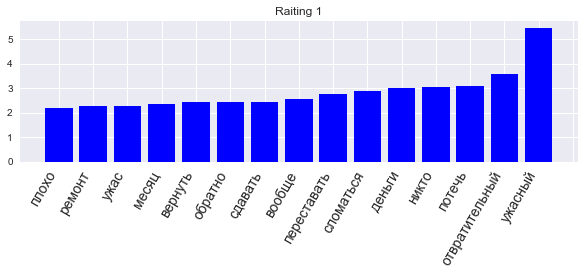

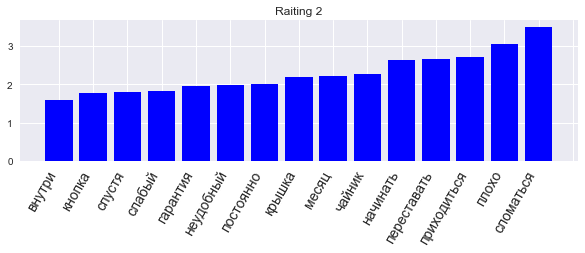

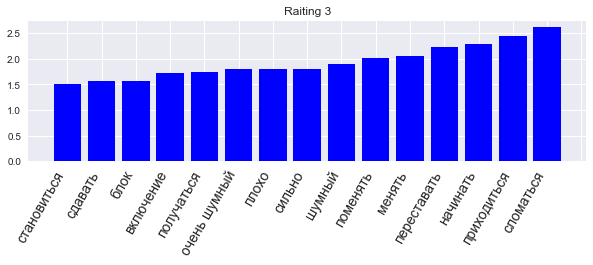

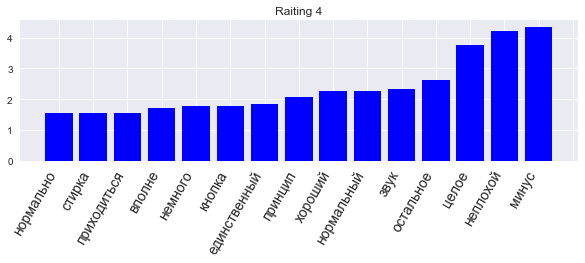

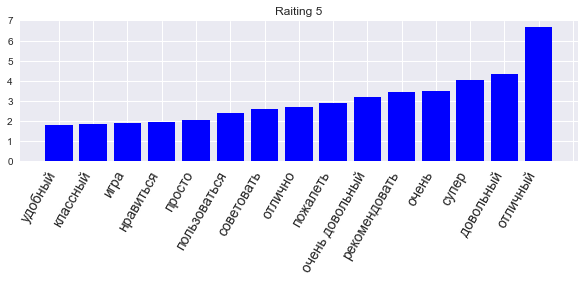

In [26]:
titles = ["Raiting {}".format(i) for i in range(1, 6)]
for i in range(5):
    visualize_coefficients(logit_sgd.coef_[i,:], tf_vectorizer.get_feature_names(),
                      title=titles[i], plot_num=i)

С интерпретацией всё довольно неплохо: 

- у самого высокого рейтинга в топе находятся крайне положительные слова, "отличный", "довольный", "супер"
- четверка чаще ставится, если встречались слова "минус", "неплохой", "нормальный"
- троечка обычно приходится на товары, у которых что-то сломалось, их надо менять, они очень шумные и т.д.
- двойка - однозначно что-то ломается, перестаёт работать, неудобно
- наконец, самые плохие оценки достаются товарам, которые просто ужасны и отвратительны и вообще нужно вернуть деньги :)

Пора посмотреть и на метрики

In [27]:
def plot_confusion(predictions, title):
    array = confusion_matrix(yval, predictions)
    df_cm = pd.DataFrame(array, index = [i for i in titles],
                      columns = [i for i in titles])
    plt.figure(figsize = (7,7))
    sns.heatmap(df_cm, annot=True, fmt='g', cbar=False)
    plt.title(title);

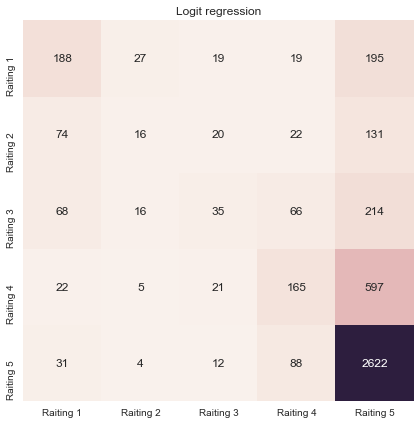

In [28]:
plot_confusion(np.array(list(map(np.argmax, logit_sgd.predict_proba(Xval))))+1, "Logit regression")

Что ж, confusion matrix не сильно радует, как и ожидалось, наш несбалансированный пятый класс оказался самым хорошо угадываемым, хотя модель часто и путает его с четверкой, а вот классы поменьше размазаны

In [29]:
print(classification_report(yval, np.array(list(map(np.argmax, logit_sgd.predict_proba(Xval))))+1))

             precision    recall  f1-score   support

          1       0.49      0.42      0.45       448
          2       0.24      0.06      0.10       263
          3       0.33      0.09      0.14       399
          4       0.46      0.20      0.28       810
          5       0.70      0.95      0.80      2757

avg / total       0.58      0.65      0.58      4677



Метрики качества также пока оставляют желать лучшего и намекают на то, что нужно переходить к двум различным моделям для избавления от несбалансированности классов. 

## Дальнешие действия

К сожалению, ограниченность времени не позволила попробовать многие подходы, но перечислить их всё же хочется
- В первую очередь, стоит попробовать натренировать отдельные модели для распознавания отличных и всех остальных отзывов, и отдельные для классов 1...4, это позволит в значительной степени решить проблему несбалансированности классов
- Во-вторых, безусловно, стоит воспользоваться различными методами понижения размерности признакового пространства, начиная с SVD, чтобы убрать шумовые признаки из разреженной матрицы, также это позволит эффективно использовать возможности других моделей, не приспособленных к работе со значительно превышающим объемы выборки числом признаков
- Наконец, семантическую окраску отзывов можно попробовать восстановить при помощи различных нейросетевых подходов, позволяющих перевести слова в векторное пространство учитывая контекст, а не опираясь на грубую предпосылку мешка слов